参考サイト：
https://di-acc2.com/programming/python/12253/

目的：
原価データを用いて、特定の商品の利益率が、売上金額・数量・各種費用のなかでどの値が最も影響力があるか数値として把握するため。
偏回帰係数を出して重みを出したい。ただし、利益率はプラスとマイナスの数値があるため、出てきた数値をどのように解釈すべきなのか熟考が必要。


データ準備

In [32]:
import pandas as pd
import numpy as np

In [34]:
#dfにはcsvそのまま挿入。
#なおcsvファイルは事前にjupyter notebookのでアップロードしておく
df = pd.read_csv("cost_jp_2022_srg.csv", sep="," , encoding='shift_jis')

In [35]:
#df2にカラム名を変更したデータフレームを挿入
df2 = df_.rename(columns={
    'JP_売上No': 'No', 
    'JP_売上金額':'Sales',
    'JP_売上数':'Quantity',
    'JP00_販管費':'Hankan',
    'JP_H0000_変動費':'Hendo',
    'JP_K0000_固定費':'Kotei',
    'JP_利益':'Rieki',
    'JP_利益率%':'Riekiritsu'
})
df2.head()

,No,Sales,Quantity,Hankan,Hendo,Kotei,Rieki,Riekiritsu
0,U3894486006,197606.0,6.0,22152.80,96835.40,22038.0,56580.19,0.40
1,U3894486043,90569.0,2.0,14601.65,59937.04,18416.4,-2385.66,0.13
2,U3894486044,101118.0,2.0,14863.70,60384.04,19375.6,6494.29,0.21
3,U3894505001,1628374.0,4.0,142056.43,599117.31,163167.0,724033.56,0.53
4,U3894513003,207255.0,9.0,29256.83,134438.10,22556.0,21004.16,0.24


In [38]:
#df3にNoを削除したデータフレームを入れる。
#drop_colに削除する列をセット
drop_col = ["No"]
#dropを実施
df3 = df2.drop(drop_col, axis=1)
df4.head()

,Sales,Quantity,Hankan,Hendo,Kotei,Rieki,Riekiritsu
0,-0.011842,-0.009668,-0.027183,-0.027246,-0.027058,0.037245,0.209018
1,-0.045736,-0.026405,-0.036268,-0.039600,-0.029515,0.016613,0.086847
2,-0.042396,-0.026405,-0.035953,-0.039451,-0.028864,0.019720,0.123046
3,0.441218,-0.018037,0.117065,0.140934,0.068697,0.270778,0.267842
4,-0.008787,0.002884,-0.018637,-0.014655,-0.026706,0.024797,0.136620


In [37]:
#df4にデータフレームの各列を正規化したデータを入れる。
df4 = df3.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
df4.head()

,Sales,Quantity,Hankan,Hendo,Kotei,Rieki,Riekiritsu
0,-0.011842,-0.009668,-0.027183,-0.027246,-0.027058,0.037245,0.209018
1,-0.045736,-0.026405,-0.036268,-0.039600,-0.029515,0.016613,0.086847
2,-0.042396,-0.026405,-0.035953,-0.039451,-0.028864,0.019720,0.123046
3,0.441218,-0.018037,0.117065,0.140934,0.068697,0.270778,0.267842
4,-0.008787,0.002884,-0.018637,-0.014655,-0.026706,0.024797,0.136620


##重回帰分析を実施

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [41]:
# 変数定義

#説明変数
X = df4[['Sales','Quantity','Hankan','Hendo','Kotei','Rieki']].values
# 目的変数（利益率）
y = df4['Riekiritsu'].values

In [42]:
# 学習データ/テストデータ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 重回帰のインスタンス
model_multi = LinearRegression()

# モデル学習
model_multi.fit(X_train, y_train)

# 予測値(学習データ）
y_train_pred = model_multi.predict(X_train)

# 予測値（テストデータ)
y_test_pred  = model_multi.predict(X_test)

In [43]:
# 偏回帰係数
df_coef = pd.DataFrame(model_multi.coef_.reshape(1,6), 
                       columns=['Sales','Quantity','Hankan','Hendo','Kotei','Rieki'])
print(df_coef)

# 切片
print('切片: %.4f' % model_multi.intercept_)

        Sales  Quantity         Hankan          Hendo         Kotei  \
0 -7085.11927  0.581616 -141293.927773  102556.052095  50610.437445   

         Rieki  
0  6414.336085  
切片: -0.0013


In [51]:
from sklearn.metrics import r2_score            # 決定係数
from sklearn.metrics import mean_squared_error  # RMSE

# 平均平方二乗誤差(RMSE)
print('RMSE 学習: %.4f, テスト: %.4f' % (
        mean_squared_error(y_train, y_train_pred), # 学習
        mean_squared_error(y_test, y_test_pred)    # テスト
      ))

# 決定係数(R^2)
print('R^2 学習: %.4f, テスト: %.4f' % (
        r2_score(y_train, y_train_pred), # 学習
        r2_score(y_test, y_test_pred)    # テスト
      ))

RMSE 学習: 0.0107, テスト: 0.0091
R^2 学習: 0.4055, テスト: 0.4646


##可視化

In [44]:
#可視化関連のライブラリインポート
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

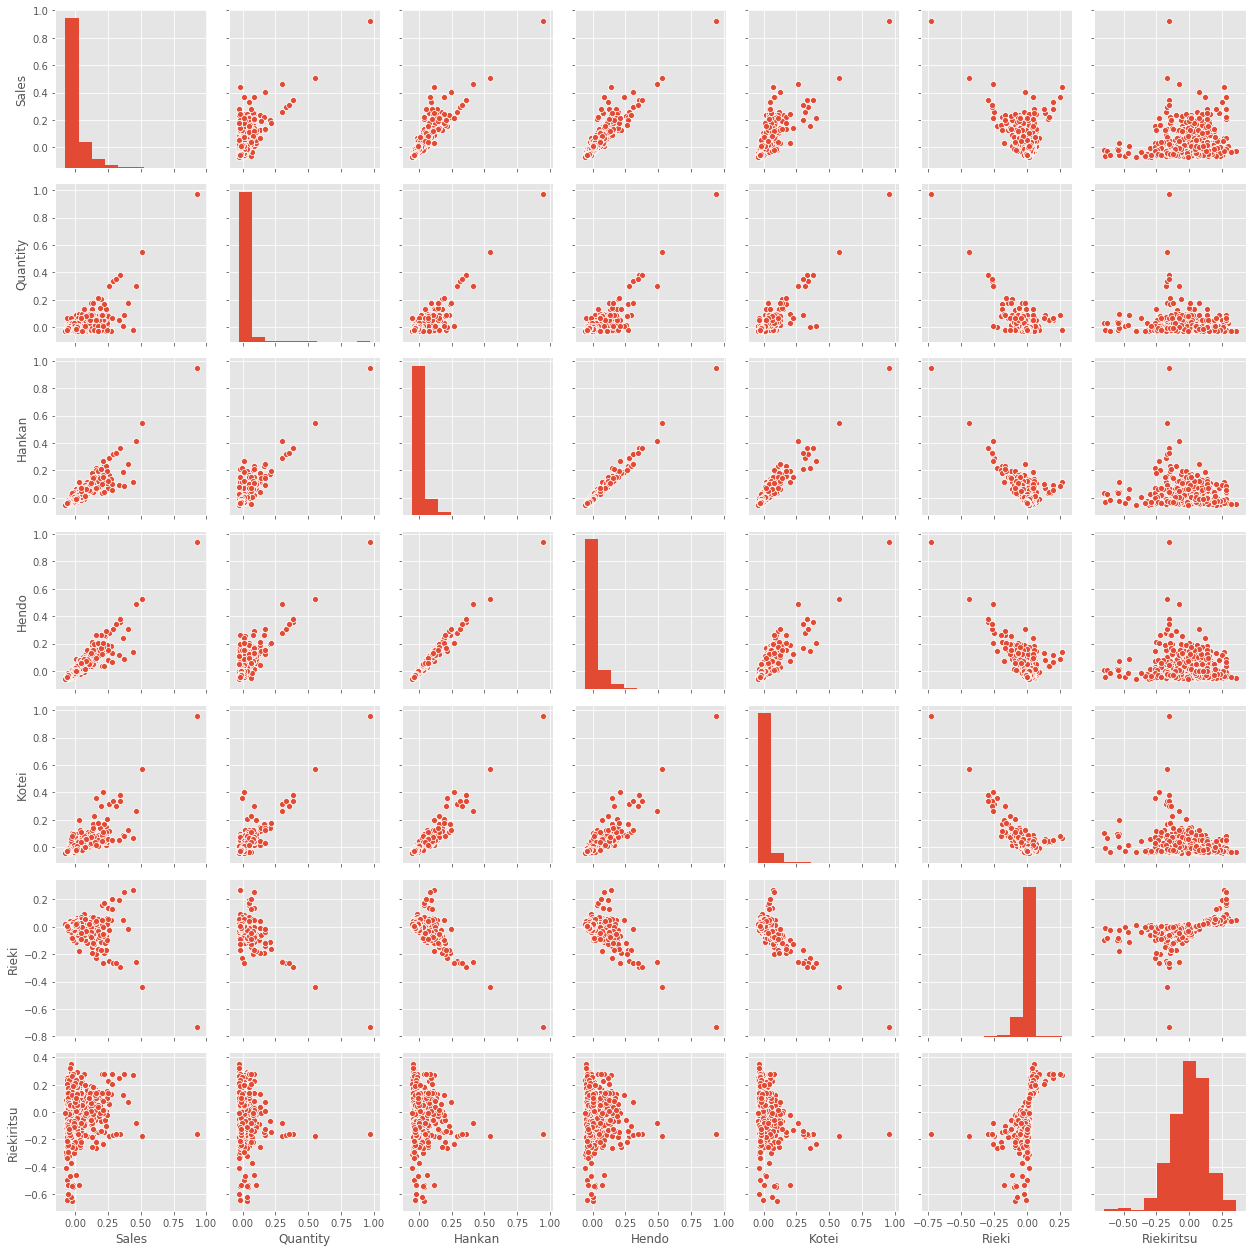

In [45]:
# 目的変数（Riekiritsu)と相関が強い変数を散布図として可視化
sns.pairplot(df4[['Sales','Quantity','Hankan','Hendo','Kotei','Rieki', 'Riekiritsu']])
plt.tight_layout()
plt.show()

#単回帰の散布図を描く

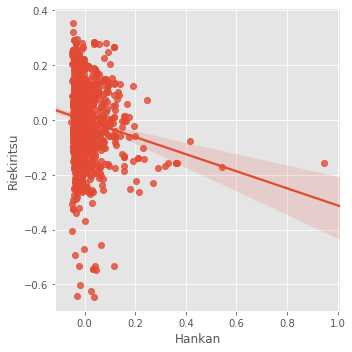

In [55]:
# 目的変数(Riekiritsu)と相関が強い変数を選択し可視化
sns.lmplot("Hankan","Riekiritsu",data=df4)
plt.tight_layout()
plt.show()

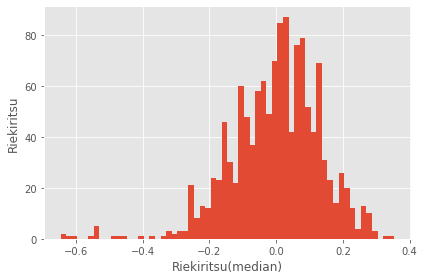

In [54]:
# 目的変数(MEDV)のヒストグラムを表示
plt.hist(df4.Riekiritsu,bins=60)
plt.xlabel("Riekiritsu(median)")
plt.ylabel("Riekiritsu")
plt.tight_layout()
plt.show()

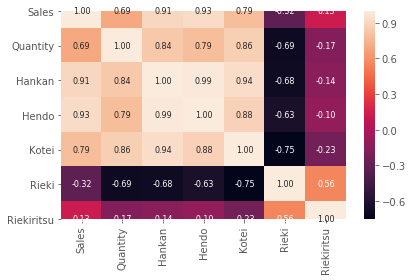

In [57]:
# 相関係数を算出
corr = np.corrcoef(df4.values.T)

# ヒートマップとして可視化
hm   = sns.heatmap(
                 corr,                         # データ
                 annot=True,                   # セルに値入力
                 fmt='.2f',                    # 出力フォーマット
                 annot_kws={'size': 8},        # セル入力値のサイズ
                 yticklabels=list(df4.columns), # 列名を出力
                 xticklabels=list(df4.columns)) # x軸を出力

plt.tight_layout()
plt.show()